In [1]:
import retro
from gym import Env
from gym.spaces import MultiBinary, Box, Discrete
import numpy as np
import cv2
from matplotlib import pyplot as plt    

In [2]:
class StreetFighter(Env):
    def __init__(self,game_state='Champion.Level1.KenVsRyu.state',record=False):
        super().__init__()
        self.observation_space = Box(low=0,high=255,shape=(84,84,1), dtype=np.uint8)
        self.action_space = Discrete(2**12)
        self.total_matches_won = 0
        self.total_enemy_matches_won = 0
        self.prev_matches_won = 0
        self.prev_enemy_matches_won = 0
        self.record = record
        # if record:
        #     self.game = retro.make(game='StreetFighterII-Champion', record='.',state=game_state,use_restricted_actions=retro.Actions.DISCRETE)
        # else:
        self.game = retro.make(game='StreetFighterII-Champion', state=game_state,use_restricted_actions=retro.Actions.DISCRETE)


    def step(self, action):
        obs, reward, done, info = self.game.step(action)
        obs_orig = obs
        obs = self.preprocess(obs)
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs
        if self.prev_matches_won > info['matches_won']:
            self.prev_matches_won = info['matches_won']
        if self.prev_enemy_matches_won > info['enemy_matches_won']:
            self.prev_enemy_matches_won = info['enemy_matches_won']
        self.total_matches_won = self.total_matches_won + info['matches_won'] - self.prev_matches_won
        self.total_enemy_matches_won = self.total_enemy_matches_won + info['enemy_matches_won'] - self.prev_enemy_matches_won
        self.prev_matches_won = info['matches_won']
        self.prev_enemy_matches_won = info['enemy_matches_won']
        reward = info['score'] - self.score
        self.score = info['score']
        self.obs_orig = obs_orig
        return frame_delta, reward, done, info
        
    def get_obs_orig(self):
        return self.obs_orig

    def render(self,*args,**kwargs):
        self.game.render()

    def reset(self):
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        self.score = 0
        self.prev_matches_won = 0
        self.prev_enemy_matches_won = 0
        return obs

    def preprocess(self, observation):
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (84,84), cv2.INTER_CUBIC)
        channels = np.reshape(resize, (84,84,1))
        return channels

    def close(self):
        self.game.close()

In [147]:
env.close()

In [5]:
env = StreetFighter()

In [6]:
obs = env.reset()
action = env.action_space.sample()
while True:
    state, reward, done, info = env.step(action)
    # if reward != 0:
    #     print(reward)
    #     print(info)
    env.render()
    if done:
        break
    action = env.action_space.sample()
env.close()

c:\Users\reece\anaconda3\envs\streetfighter37\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


In [3]:
import optuna
import os
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
LOG_DIR = './logs/DQN/Ken'
OPT_DIR = './opt/DQN/Ken'
CHECKPOINT_DIR = './train/DQN/Ken'

In [5]:
def optimize(trial):
    return {
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-5,1e-4),
        'gamma':trial.suggest_loguniform('gamma', 0.8,0.9999),
        'tau':trial.suggest_loguniform('tau', 0.001,0.01),
    }

In [145]:
env.close()

In [6]:
def optimize_agent(trial):
    try:
        model_params = optimize(trial)
        env = StreetFighter()
        env = Monitor(env,LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env,4,channels_order='last')

        model = DQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=0,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
        model.learn(total_timesteps=10000)

        mean_reward, _ = evaluate_policy(model,env,n_eval_episodes=10)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        print(mean_reward)
        
        return mean_reward
    except Exception as e:
        print(e)
        return -1000

In [7]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent,n_trials=10,n_jobs=1)

[I 2024-04-21 11:00:28,609] A new study created in memory with name: no-name-b0b92b46-87b7-4a58-b3ac-bd46bc8a43bf
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  after removing the cwd from sys.path.
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This

1200.0


[I 2024-04-21 11:05:53,148] Trial 1 finished with value: 200.0 and parameters: {'learning_rate': 2.0066161352259923e-05, 'gamma': 0.8061410267949127, 'tau': 0.0023095538956652197}. Best is trial 0 with value: 1200.0.


200.0


[I 2024-04-21 11:07:56,230] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 2.0382494497267446e-05, 'gamma': 0.896831550203947, 'tau': 0.0021429912634755234}. Best is trial 0 with value: 1200.0.


0.0


[I 2024-04-21 11:11:00,224] Trial 3 finished with value: 1100.0 and parameters: {'learning_rate': 4.10387386952234e-05, 'gamma': 0.9655197674607953, 'tau': 0.0014273486547409422}. Best is trial 0 with value: 1200.0.


1100.0


[I 2024-04-21 11:13:30,777] Trial 4 finished with value: 800.0 and parameters: {'learning_rate': 3.902694701905836e-05, 'gamma': 0.8175603265894009, 'tau': 0.0034150538084659573}. Best is trial 0 with value: 1200.0.


800.0


[I 2024-04-21 11:16:06,047] Trial 5 finished with value: 500.0 and parameters: {'learning_rate': 8.511883513709151e-05, 'gamma': 0.8557195005823232, 'tau': 0.0020922811360833227}. Best is trial 0 with value: 1200.0.


500.0


[I 2024-04-21 11:18:15,610] Trial 6 finished with value: 600.0 and parameters: {'learning_rate': 9.341908955595047e-05, 'gamma': 0.8619972459533234, 'tau': 0.0020216738547603856}. Best is trial 0 with value: 1200.0.


600.0


[I 2024-04-21 11:20:42,487] Trial 7 finished with value: 300.0 and parameters: {'learning_rate': 1.7701352565027112e-05, 'gamma': 0.8393667459992751, 'tau': 0.00406526617535556}. Best is trial 0 with value: 1200.0.


300.0


[I 2024-04-21 11:23:42,102] Trial 8 finished with value: 2400.0 and parameters: {'learning_rate': 1.652009725879022e-05, 'gamma': 0.94667260001411, 'tau': 0.006644902426015791}. Best is trial 8 with value: 2400.0.


2400.0


[I 2024-04-21 11:26:26,407] Trial 9 finished with value: 300.0 and parameters: {'learning_rate': 9.314376079977866e-05, 'gamma': 0.9487648759145528, 'tau': 0.0010100455774978104}. Best is trial 8 with value: 2400.0.


300.0


In [8]:
study.best_trial

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[2400.0], datetime_start=datetime.datetime(2024, 4, 21, 11, 20, 42, 488775), datetime_complete=datetime.datetime(2024, 4, 21, 11, 23, 42, 101316), params={'learning_rate': 1.652009725879022e-05, 'gamma': 0.94667260001411, 'tau': 0.006644902426015791}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'gamma': FloatDistribution(high=0.9999, log=True, low=0.8, step=None), 'tau': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, trial_id=8, value=None)

In [9]:
study.best_params

{'learning_rate': 1.652009725879022e-05,
 'gamma': 0.94667260001411,
 'tau': 0.006644902426015791}

In [5]:
from stable_baselines3.common.callbacks import BaseCallback

In [7]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback,self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}_'.format(self.n_calls))
            self.model.save(model_path)
            self.logger.record('matches_won', self.training_env.get_attr('total_matches_won')[0])
            self.logger.record('enemy_matches_won', self.training_env.get_attr('total_enemy_matches_won')[0])

        return True

In [8]:
callback = TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

In [25]:
env.close()

In [9]:
env = StreetFighter()
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [10]:
model_params = {}
model_params['learning_rate'] = 1.652009725879022e-05
model_params['gamma'] = 0.94667260001411
model_params['tau'] = 0.006644902426015791

In [11]:
model = DQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=2,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
# model.load(os.path.join(OPT_DIR, 'trial_0_best_model.zip'))
model.load(os.path.join(OPT_DIR, 'trial_8_best_model.zip'))
model.learn(total_timesteps=1000000,callback=callback)
# can increase training time and learning rate later

Using cpu device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/DQN/Ken\DQN_21
----------------------------------
| enemy_matches_won   | 7        |
| matches_won         | 2        |
| rollout/            |          |
|    ep_len_mean      | 5.21e+03 |
|    ep_rew_mean      | 1.22e+04 |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1122     |
|    time_elapsed     | 18       |
|    total_timesteps  | 20857    |
----------------------------------
----------------------------------
| enemy_matches_won   | 14       |
| matches_won         | 4        |
| rollout/            |          |
|    ep_len_mean      | 6.05e+03 |
|    ep_rew_mean      | 1.18e+04 |
|    exploration_rate | 0.54     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1128     |
|    time_elapsed     | 42       |
|    total_timesteps  | 48431    |
----------------------------------

In [13]:
env = StreetFighter()
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [13]:
model = DQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_500000_'))
# best 1000000 - 1400
# best 50000 - 3300
# model = DQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=2,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=5)
print(mean_reward)

3300.0


In [14]:
from matplotlib import animation
import matplotlib.pyplot as plt

In [15]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=180)

In [17]:
env.close()

MovieWriter imagemagick unavailable; using Pillow instead.


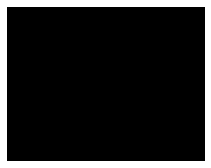

In [18]:
"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""

#Make gym env
my_env = StreetFighter()
env = Monitor(my_env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

model = DQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_50000_'))
obs = env.reset()
done = False
frames = []

while not done:
    if done:
        break
    # frames.append(env.render(mode="rgb_array"))
    env.render()
    obs,reward,done,info = env.step(model.predict(obs)[0])
    rec_obs = my_env.get_obs_orig()
    frames.append(rec_obs)
env.close()

save_frames_as_gif(frames)